In [71]:
# matplotlib==3.5.0 is required for tikzplotlib to work 
# see https://github.com/texworld/tikzplotlib/pull/558
!pip install tikzplotlib numpy matplotlib==3.5.0 scipy Pillow

In [73]:
import re
import numpy as np
from scipy.spatial import distance_matrix

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import tikzplotlib

In [15]:
print(tikzplotlib.Flavors.latex.preamble())

\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}



In [11]:
darkred = "#8b0000"
darkgreen = "#006400"

EXPORT_ROOT = "../images/"

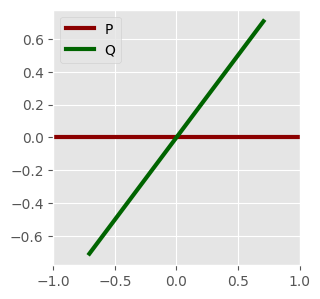

In [135]:
# Free space bird from paper
# p_coord = [[-1, -0.5], [0.5, 0.5], [-0.5,1], [-0.5,-0.5], [0.4, -0.15], [0.6, -0.3]]
# q_coord = [[-0.5, -1], [-1,0], [0,0], [0,1], [-1,0.5], [0.5,-0.5],]

# Two line segmens
p_coord = [[-1,0], [1,0]]
q_coord = [[np.cos(np.pi + np.pi/4), np.sin(np.pi + np.pi/4)], [np.cos(np.pi/4), np.sin(np.pi/4)]]

# p_coord = [[0,0.8], [0,1], [1.25,1], [1.4,0.9], [1.5,1], [2,1]]
# q_coord = [[-0.1,1], [1,1.1], [1.5,1.3], [1.8,1], [2,1]]

pxs, pys = zip(*p_coord)
qxs, qys = zip(*q_coord)


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))

p_plot, = ax.plot(pxs, pys, label="P", color=darkred, linewidth=3)
q_plot, = ax.plot(qxs, qys, label="Q", color=darkgreen, linewidth=3)
ax.set_xbound(lower=-1, upper=1)
ax.legend(handles = [p_plot, q_plot], frameon=True)

plt.tight_layout()
factor = 1
plt.gcf().set_size_inches(2.70134 * factor, 2.70134 * factor)

plt.savefig(EXPORT_ROOT + "/frechet_distance/line_segments.pdf", format="pdf")
tikzplotlib.clean_figure()
tikzplotlib.save(EXPORT_ROOT + "/frechet_distance/line_segments.tex", strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

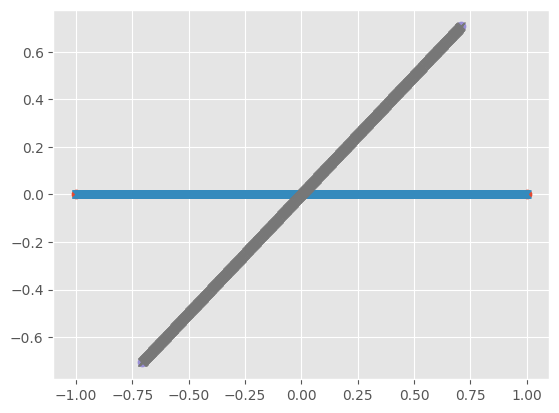

In [136]:
def interpolate_polygonal_curve(polygonal_curve):


  diffs = np.diff(polygonal_curve, axis=0)
  dists = np.linalg.norm(diffs, ord=2, axis=1)
  dist = np.sum(dists)

  distance_sample_points = np.insert(np.cumsum(dists), 0, 0, axis=0)

  x_coords, y_coords = zip(*polygonal_curve)

  new_intervals = np.linspace(0, dist, 1000)
  new_x_coords = np.interp(new_intervals, distance_sample_points, x_coords)
  new_y_coords = np.interp(new_intervals, distance_sample_points, y_coords)

  return np.vstack((new_x_coords, new_y_coords)).T

# Plot P
x_coords, y_coords = zip(*p_coord)
new_p_coords = interpolate_polygonal_curve(p_coord)
new_x_p_coords, new_y_q_coords = np.moveaxis(new_p_coords, 1, 0)

plt.plot(x_coords, y_coords, '-o')
plt.plot(new_x_p_coords, new_y_q_coords, '-x')


# Plot Q
x_coords, y_coords = zip(*q_coord)
new_q_coords = interpolate_polygonal_curve(q_coord)
new_x_q_coords, new_y_q_coords = np.moveaxis(new_q_coords, 1, 0)

plt.plot(x_coords, y_coords, '-o')
plt.plot(new_x_q_coords, new_y_q_coords, '-x')

plt.show()

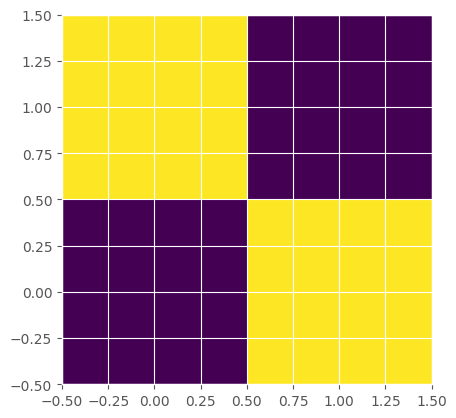

In [137]:
dists = distance_matrix(p_coord, q_coord)

plt.imshow(dists)
ax = plt.gca()
ax.invert_yaxis()

In [138]:
palette = np.array([[245, 245, 245],   # white
                    [30, 30, 30],   # black border
                    [150, 150, 150],   # gray
                    ])

0.7653668647301795 0.7653668647301795


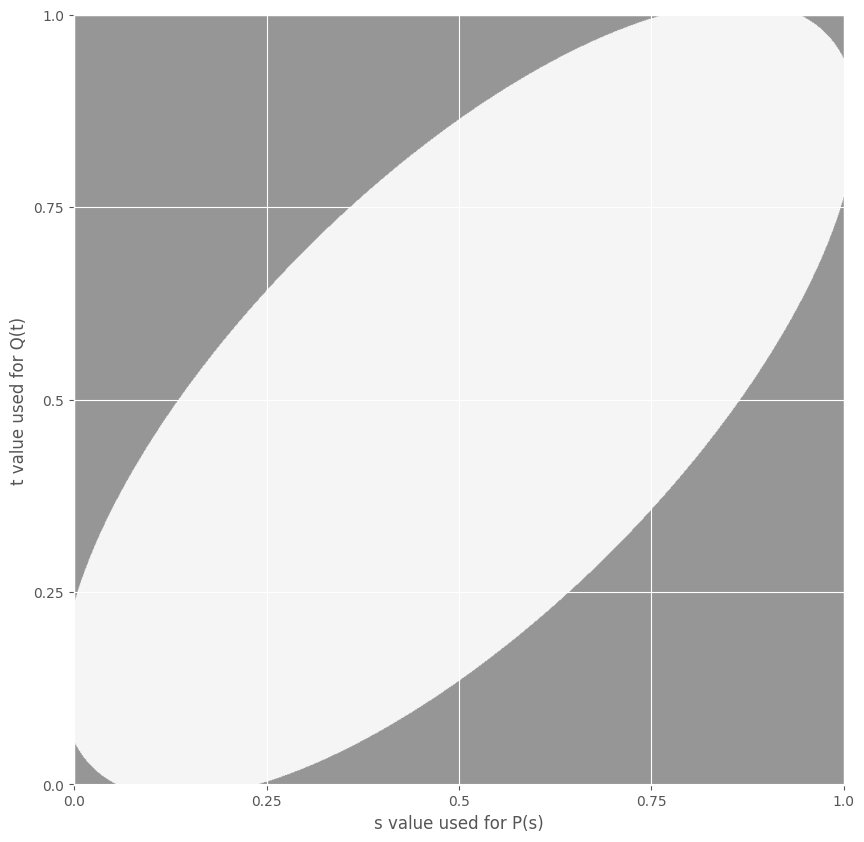

In [139]:
dists = distance_matrix(new_p_coords, new_q_coords)

print(dists[0,0], dists[-1,-1])
threshold = 0.73
epsilon = 0

plot_pixels = np.zeros_like(dists, dtype="int")
plot_pixels[dists  >= threshold + epsilon] = 2
plot_pixels[(dists  < threshold + epsilon) & (dists  > threshold - epsilon)] = 1
plot_pixels[dists  <= threshold - epsilon] = 0


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))


ax.imshow(palette[plot_pixels.T])
# plt.colorbar()
ax.invert_yaxis()
ax.set_xlabel("s value used for P(s)")
ax.set_ylabel("t value used for Q(t)")
ax.set_xticks(np.linspace(0, len(new_p_coords), num=5), np.linspace(0,1, num=5))
ax.set_yticks(np.linspace(0, len(new_q_coords), num=5), np.linspace(0,1, num=5))

filename = "free_space_single_cell"
plt.savefig(EXPORT_ROOT + "/frechet_distance/" + filename + ".pdf", format="pdf")

tex_path = EXPORT_ROOT + "/frechet_distance/" + filename + ".tex"
tikzplotlib.clean_figure()
tikzplotlib.save(tex_path, strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

# post processing of plot
# fix relative path
with open(tex_path, "r") as f:
    tex = f.read()
matches = re.search(r"\{(.+\.png)\};", tex)
png_file_name = matches.groups(0)[0]
tex = tex.replace(png_file_name, "images/frechet_distance/" + filename + "_image.png")
with open(tex_path, "w") as f:
    f.write(tex)

# fix image orientation
png_path = EXPORT_ROOT + "/frechet_distance/" + png_file_name
original_img = Image.open(png_path)
original_img = original_img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
original_img.save(EXPORT_ROOT + "/frechet_distance/" + filename + "_image.png")
original_img.close()

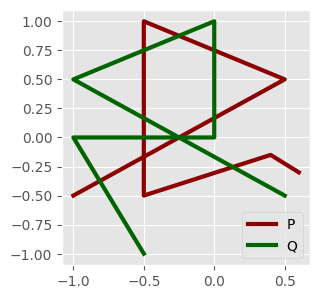

In [140]:
# Free space bird from paper
p_coord = [[-1, -0.5], [0.5, 0.5], [-0.5,1], [-0.5,-0.5], [0.4, -0.15], [0.6, -0.3]]
q_coord = [[-0.5, -1], [-1,0], [0,0], [0,1], [-1,0.5], [0.5,-0.5]]

pxs, pys = zip(*p_coord)
qxs, qys = zip(*q_coord)


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))

p_plot, = ax.plot(pxs, pys, label="P", color=darkred, linewidth=3)
q_plot, = ax.plot(qxs, qys, label="Q", color=darkgreen, linewidth=3)
ax.legend(handles = [p_plot, q_plot], frameon=True)

plt.tight_layout()
factor = 1
plt.gcf().set_size_inches(2.70134 * factor, 2.70134 * factor)

plt.savefig(EXPORT_ROOT + "/frechet_distance/polygonal_curves.pdf", format="pdf")
tikzplotlib.clean_figure()
tikzplotlib.save(EXPORT_ROOT + "/frechet_distance/polygonal_curves.tex", strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

0.7071067811865476 0.22360679774997896


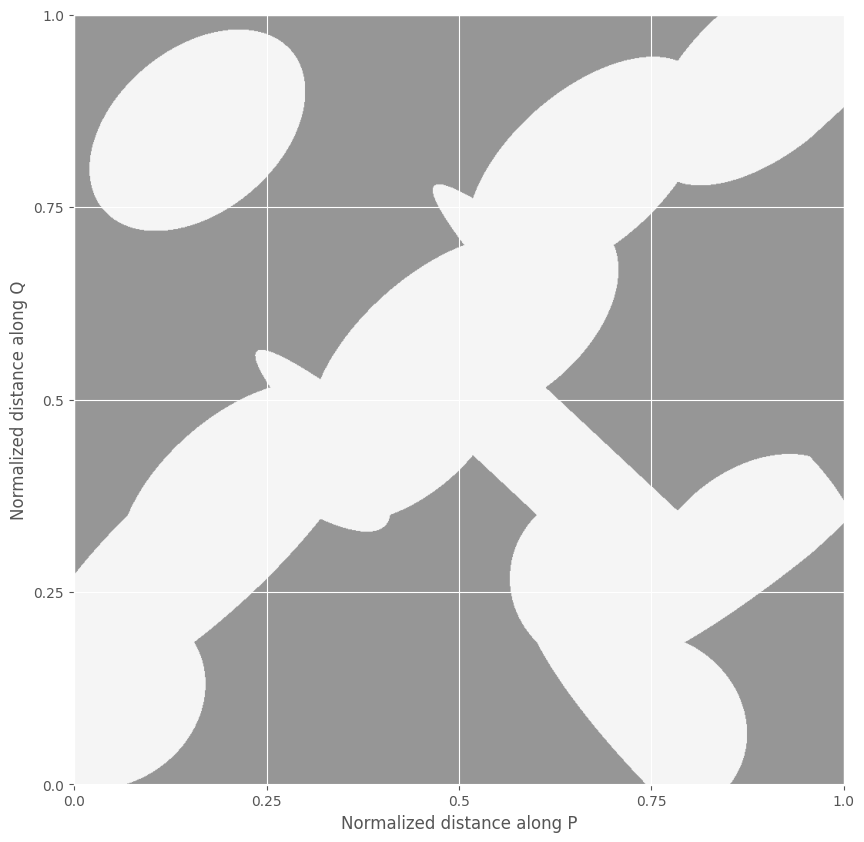

In [147]:
new_p_coords = interpolate_polygonal_curve(p_coord)
new_q_coords = interpolate_polygonal_curve(q_coord)
dists = distance_matrix(new_p_coords, new_q_coords)

print(dists[0,0], dists[-1,-1])
threshold = 0.73
epsilon = 0

plot_pixels = np.zeros_like(dists, dtype="int")
plot_pixels[dists  >= threshold + epsilon] = 2
plot_pixels[(dists  < threshold + epsilon) & (dists  > threshold - epsilon)] = 1
plot_pixels[dists  <= threshold - epsilon] = 0


plt.style.use("ggplot")
fig, ax = plt.subplots(1, figsize=(10,10))


ax.imshow(palette[plot_pixels.T])


ax.invert_yaxis()
ax.set_xlabel("Normalized distance along P")
ax.set_ylabel("Normalized distance along Q")
ax.set_xticks(np.linspace(0, len(new_p_coords), num=5), np.linspace(0,1, num=5))
ax.set_yticks(np.linspace(0, len(new_q_coords), num=5), np.linspace(0,1, num=5))

filename = "free_space_polygonal_curves"
plt.savefig(EXPORT_ROOT + "/frechet_distance/" + filename + ".pdf", format="pdf")

tex_path = EXPORT_ROOT + "/frechet_distance/" + filename + ".tex"
tikzplotlib.clean_figure()
tikzplotlib.save(tex_path, strict=True, axis_width='\\textwidth', axis_height='\\textwidth')

# post processing of plot
# fix relative path
with open(tex_path, "r") as f:
    tex = f.read()
matches = re.search(r"\{(.+\.png)\};", tex)
png_file_name = matches.groups(0)[0]
tex = tex.replace(png_file_name, "images/frechet_distance/" + filename + "_image.png")
with open(tex_path, "w") as f:
    f.write(tex)

# fix image orientation
png_path = EXPORT_ROOT + "/frechet_distance/" + png_file_name
original_img = Image.open(png_path)
original_img = original_img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
original_img.save(EXPORT_ROOT + "/frechet_distance/" + filename + "_image.png")
original_img.close()
